In [110]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import h5py
import numpy as np
import os
import sys
import torch
import yaml
from scipy.optimize import curve_fit
from IPython.display import display, Markdown, Latex

%load_ext autoreload
%autoreload 2
sys.path.insert(1, '../code')
from geometric_features import GeometricFeaturizer, geo_name
from scalar_features import ScalarFeaturizer, scalar_name
from read_halos import SimulationReader
from fit import LinearFitter
from neural_net import NeuralNet, NNFitter
import plotter
import utils
import feature_importance

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
sim_name = 'TNG100-1'
#sim_name = 'TNG50-4'
sim_name_dark = f'{sim_name}-Dark'

halo_tag = ''
geo_tag = ''
scalar_tag = ''
mass_multiplier = 1e10
log_mass_shift = 10

## Load features

In [3]:
fn_halo_config = f'../configs/halos_{sim_name}{halo_tag}.yaml'
print(fn_halo_config)
fn_geo_config = f'../configs/geo_{sim_name}{halo_tag}{geo_tag}.yaml'
print(fn_geo_config)
fn_scalar_config = f'../configs/scalar_{sim_name}{halo_tag}{geo_tag}{scalar_tag}.yaml'
print(fn_scalar_config)

../configs/halos_TNG100-1.yaml
../configs/geo_TNG100-1.yaml
../configs/scalar_TNG100-1.yaml


In [4]:
with open(fn_scalar_config, 'r') as file:
    scalar_params = yaml.safe_load(file)
scp = scalar_params['scalar']

fn_geo_config = scalar_params['geo']['fn_geo_config']
with open(fn_geo_config, 'r') as file:
    geo_params = yaml.safe_load(file)
gp = geo_params['geo']

with open(fn_halo_config, 'r') as file:
    halo_params = yaml.safe_load(file)

fn_dark_halo_arr = halo_params['halo']['fn_dark_halo_arr']

In [5]:
geo_featurizer = GeometricFeaturizer()
geo_featurizer.load_features(gp['fn_geo_features'])

In [6]:
sim_reader = SimulationReader(halo_params['sim']['base_dir'], sim_name, sim_name_dark, 
                              halo_params['sim']['snap_num_str'])
sim_reader.load_dark_halo_arr(fn_dark_halo_arr)
sim_reader.read_simulations()

In [7]:
mrv_for_rescaling = utils.get_mrv_for_rescaling(sim_reader, scp['mrv_names_for_rescaling'])
scalar_featurizer = ScalarFeaturizer(geo_featurizer.geo_feature_arr,
                        n_groups_rebin=scp['n_groups_rebin'], 
                        transform_pseudotensors=scp['transform_pseudotensors'], 
                        mrv_for_rescaling=mrv_for_rescaling)

Rebinning geometric features
Transforming pseudotensors
Rescaling geometric features


In [8]:
x_features_extra = np.log10(mrv_for_rescaling).T

In [9]:
print('loading')
scalar_featurizer.load_features(scp['fn_scalar_features'])
print('loaded')

loading
loaded


## Other features

In [10]:
x_dict = {}
x_extra_dict = {}

In [11]:
x_dict['scalars'] = scalar_featurizer.scalar_features
x_extra_dict['scalars'] = x_features_extra

x_dict['geos'] = utils.geo_feature_arr_to_values(scalar_featurizer.geo_feature_arr)
x_extra_dict['geos'] = x_features_extra

x_dict['mrv'] = x_features_extra
x_extra_dict['mrv'] = None

catalog_feature_names = ['M200c', 'c200c', 'a_form']
sim_reader.get_structure_catalog_features(catalog_feature_names)
x_dict['catalog'] = sim_reader.x_catalog_features
x_extra_dict['catalog'] = None

## Gather properties

In [12]:
sim_reader.add_catalog_property_to_halos('m200m')
m_200m = np.array([dark_halo.catalog_properties['m200m'] for dark_halo in sim_reader.dark_halo_arr])
log_m_200m = np.log10(m_200m)

## Split train-val-test

In [13]:
frac_train = 0.70
frac_val = 0.15
frac_test = 0.15

random_ints = np.array([dark_halo.random_int for dark_halo in sim_reader.dark_halo_arr])
idx_train, idx_val, idx_test = utils.split_train_val_test(random_ints, frac_train=frac_train, 
                                                      frac_val=frac_val, frac_test=frac_test)

In [14]:
x_test = scalar_featurizer.scalar_features[idx_test]
y_test_current = None
x_test_extra = x_features_extra[idx_test]

## Mstellar

In [50]:
y_label_name = 'm_stellar'

In [64]:
fit_tag = f'_{y_label_name}_nn_scalars_epochs500_lr5e-05_hs128_f0.01'

fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'

In [65]:
y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]

In [66]:
nnfitter = NNFitter()
nnfitter.load_model(fn_model)

In [67]:
import torch
model_checkpoint = torch.load(fn_model)

266 10.528742119867816


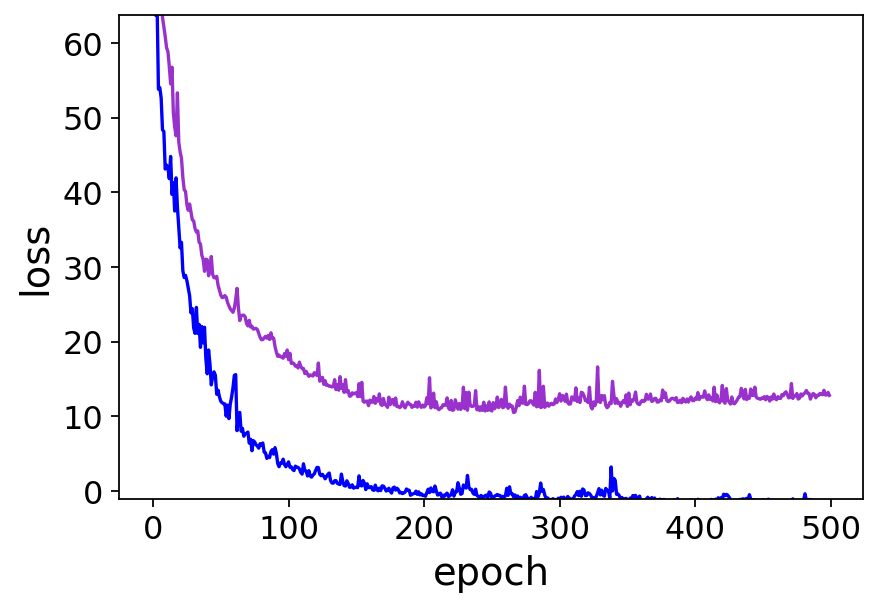

In [68]:
plt.plot(nnfitter.loss_valid, color='darkorchid', label='Validation')
plt.plot(nnfitter.loss_train, color='blue', label='Training')
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.ylim(0,300)
plt.ylim(-1, nnfitter.loss_train[2])
print(np.argmin(nnfitter.loss_valid), np.min(nnfitter.loss_valid))

In [69]:
# plt.plot(nnfitter.loss, color='darkorchid')
# plt.xlabel('epoch')
# plt.ylabel('loss')

In [70]:
y_pred = nnfitter.predict(x_test, y_current=y_test_current, x_extra=x_test_extra)

/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:327: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


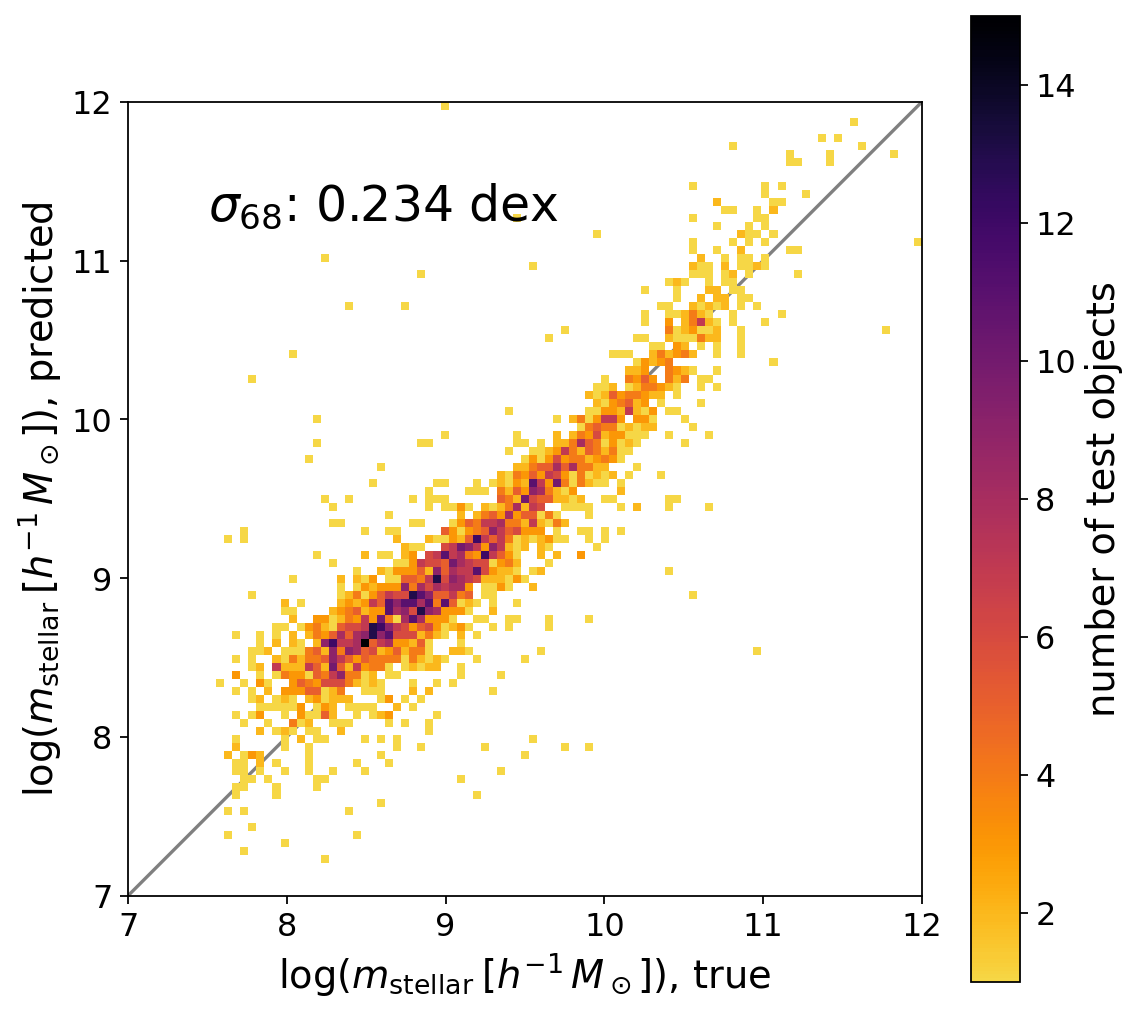

In [71]:
y_test_mult = y_test + log_mass_shift
y_pred_mult = y_pred + log_mass_shift
error_nn, _ = utils.compute_error(y_test_mult, y_pred_mult, test_error_type='percentile')
error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"
plotter.plot_pred_vs_true_hist(y_label_name, y_test_mult, y_pred_mult, text_results=error_str,
                               x_lim=(7,12),  y_lim=(7,12))

In [27]:
def plot_error_fig(y_true, y_pred):
    plt.figure()
    bins = np.linspace(np.min(y_true), np.max(y_true), 14)
    delta_y = y_pred - y_true
    delta_y_binned = np.empty(len(bins)-1)
    for i in range(len(bins)-1):
        idx_inbin = (y_true >= bins[i]) & (y_true < bins[i+1])
        delta_y_binned[i] = np.median(delta_y[idx_inbin])
    bins_avg = 0.5*(bins[1:] + bins[:-1])
    plt.plot(bins_avg, delta_y_binned)

# training set size dep

In [129]:
y_label_name = 'm_stellar'

In [130]:
y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]

In [131]:
sfeat = scalar_featurizer.scalar_features

In [132]:
feature_names = ['geos', 'scalars']
fracs_subset = [0.005, 0.01, 0.05, 0.1, 0.5, 1]
errors = []
for ff, feature_name in enumerate(feature_names):
    errors_feature = []
    x = x_dict[feature_name]
    x_extra = x_extra_dict[feature_name]
    if x is not None:
        x_test = x[idx_test]
    else:
        x_test = None
    if x_extra is not None:
        x_test_extra = x_extra[idx_test]
    else:
        x_test_extra = None
        
    for i, frac_subset in enumerate(fracs_subset):
        # this is just cuz i kept doing diff ones, eventually standardize max_epochs and f tag
        if frac_subset == 1.0:
            frac_tag = ''
            max_epochs = 1000
        elif frac_subset<=0.05:
            frac_tag = f'_f{frac_subset}'
            max_epochs = 500            
        else:
            frac_tag = f'_f{frac_subset}'
            max_epochs = 2000
            
        fit_tag = f'_{y_label_name}_nn_{feature_name}_epochs{max_epochs}_lr5e-05_hs128{frac_tag}'
        fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'
        nnfitter = NNFitter()
        nnfitter.load_model(fn_model)
        y_pred = nnfitter.predict(x_test, y_current=y_test_current, x_extra=x_test_extra)
        y_test_mult = y_test + log_mass_shift
        y_pred_mult = y_pred + log_mass_shift
        error, _ = utils.compute_error(y_test_mult, y_pred_mult, test_error_type='percentile')
        errors_feature.append(error)
    
    errors.append(errors_feature)

In [133]:
ns_train = np.array(fracs_subset) * len(idx_train)

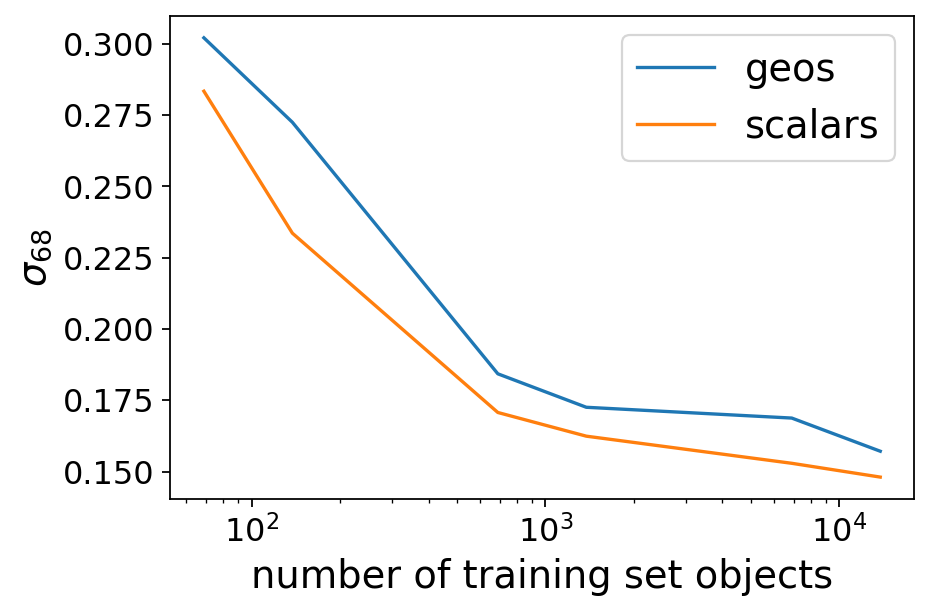

In [134]:
for ff, feature_name in enumerate(feature_names):
    plt.plot(ns_train, errors[ff], label=feature_name)

plt.legend()
plt.xlabel('number of training set objects')
plt.ylabel(r'$\sigma_{68}$')
plt.xscale('log')
#plt.yscale('log')

# dependence on top n features (spearman)

In [84]:
y_label_name = 'm_stellar'

In [85]:
y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]

In [86]:
sfeat = scalar_featurizer.scalar_features

In [121]:
feature_name = 'scalars'
info_metric = 'spearman'
ns_top_features = [1, 5, 10, 50, 100, 567]
frac_subset = 1.0
errors = []

x = x_dict[feature_name]
x_extra = x_extra_dict[feature_name]
if x is not None:
    x_test = x[idx_test]
else:
    x_test = None
if x_extra is not None:
    x_test_extra = x_extra[idx_test]
else:
    x_test_extra = None

feature_info_dir = f'../data/feature_info/feature_info_{sim_name}'
fn_feature_info = f'{feature_info_dir}/feature_info_{sim_name}{halo_tag}{geo_tag}{scalar_tag}_{info_metric}_{y_label_name}.npy'
values = np.load(fn_feature_info, allow_pickle=True)
i_info_ordered = np.argsort(values)[::-1]
    
for i, n_top_features in enumerate(ns_top_features):
    # this is just cuz i kept doing diff ones, eventually standardize max_epochs and f tag
    i_info = i_info_ordered[:n_top_features]
    print(len(i_info))
    print(x_test.shape)
    x_test_top = x_test[:,i_info]

    info_tag = f'_{info_metric}{n_top_features}'
    max_epochs = 500
    frac_tag = ''
    if frac_subset != 1.0:
        frac_tag = f'_f{frac_subset}'
    fit_tag = f'_{y_label_name}_nn_{feature_name}_epochs{max_epochs}_lr5e-05_hs128{frac_tag}{info_tag}'
    print(fit_tag)
    fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'
    nnfitter = NNFitter()
    nnfitter.load_model(fn_model)
    y_pred = nnfitter.predict(x_test_top, y_current=y_test_current, x_extra=x_test_extra)
    y_test_mult = y_test + log_mass_shift
    y_pred_mult = y_pred + log_mass_shift
    error, _ = utils.compute_error(y_test_mult, y_pred_mult, test_error_type='percentile')
    print(error)
    errors.append(error)

1
(2951, 567)
_m_stellar_nn_scalars_epochs500_lr5e-05_hs128_spearman1
0.24247090800318638
5
(2951, 567)
_m_stellar_nn_scalars_epochs500_lr5e-05_hs128_spearman5
0.25045364275981274
10
(2951, 567)
_m_stellar_nn_scalars_epochs500_lr5e-05_hs128_spearman10
0.211528550058647
50
(2951, 567)
_m_stellar_nn_scalars_epochs500_lr5e-05_hs128_spearman50
0.20661543014984574
100
(2951, 567)
_m_stellar_nn_scalars_epochs500_lr5e-05_hs128_spearman100
0.15483582121986839
567
(2951, 567)
_m_stellar_nn_scalars_epochs500_lr5e-05_hs128_spearman567
0.1506263499393219


In [122]:
s_arr_0 = scalar_featurizer.scalar_feature_arr[0]

In [127]:
for ii in range(567):
    print(ii, display(Markdown(scalar_name(s_arr_0[i_info_ordered[ii]], scalar_featurizer.geo_feature_arr))))

$\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_3\left(C^{xx}_2\right)$

0 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(C^{vv}_1\right)$

1 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_2\left(C^{vv}_2\right)$

2 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_3\left(C^{xx}_2\right)$

3 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_2\left(C^{xx}_2\right)$

4 None


$\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

5 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right)$

6 None


$\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

7 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(C^{xx}_1\right)$

8 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_3\left(C^{xx}_1\right)$

9 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_2\left(C^{xx}_2\right)$

10 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_3\left(C^{vv}_2\right)$

11 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_2\left(C^{xx}_1\right)$

12 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_2\left(C^{vv}_2\right)$

13 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_2\left(C^{vv}_1\right)$

14 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_3\left(C^{vv}_1\right)$

15 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right) \, \lambda_3\left(C^{xx}_2\right)$

16 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_3\left(C^{xx}_1\right)$

17 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(C^{vv}_2\right)$

18 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_2\left(C^{xx}_1\right)$

19 None


$\lambda_1\left(C^{vv}_1\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

20 None


$\lambda_1\left(C^{vv}_1\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

21 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, m_2$

22 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_3\left(C^{vv}_2\right)$

23 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right) \, \lambda_2\left(C^{xx}_2\right)$

24 None


$\lambda_2\left(C^{vv}_2\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

25 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, m_1$

26 None


$\lambda_2\left(C^{vv}_1\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

27 None


$\lambda_1\left(C^{xx}_1\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

28 None


$\lambda_3\left(C^{xx}_1\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

29 None


$\lambda_2\left(C^{xx}_1\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

30 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_1\left(C^{vv}_2\right)$

31 None


$\lambda_3\left(C^{vv}_1\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

32 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, m_2$

33 None


$\lambda_2\left(C^{vv}_1\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

34 None


$\lambda_3\left(C^{vv}_2\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

35 None


$\lambda_3\left(C^{vv}_1\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

36 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(C^{xx}_2\right)$

37 None


$\lambda_1\left(C^{vv}_2\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

38 None


$m_1 \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

39 None


$\lambda_3\left(C^{xx}_0\right) \, \lambda_2\left(C^{xx}_0\right)$

40 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_1\left(C^{xx}_1\right)$

41 None


$\lambda_1\left(C^{vv}_0\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

42 None


$m_2 \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

43 None


$\lambda_1\left(C^{vv}_0\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

44 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_1\left(C^{xx}_2\right)$

45 None


$\lambda_2\left(C^{vv}_0\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

46 None


$\lambda_3\left(C^{vv}_0\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

47 None


$m_1 \, \lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

48 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

49 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right) \, \lambda_1\left(C^{xx}_2\right)$

50 None


$m_0 \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

51 None


$\lambda_1\left(C^{xx}_0\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

52 None


$[v_0]_{j} \, [v_2]_{j}$

53 None


$\lambda_2\left(C^{xx}_0\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

54 None


$\lambda_2\left(C^{vv}_0\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

55 None


$\lambda_3\left(C^{xx}_0\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

56 None


$\lambda_2\left(C^{xx}_0\right)$

57 None


$\lambda_2\left(C^{xx}_0\right) \, \lambda_2\left(C^{xx}_0\right)$

58 None


$\lambda_3\left(C^{xx}_0\right) \, \lambda_1\left(C^{xx}_0\right)$

59 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

60 None


$\lambda_3\left(C^{vv}_0\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

61 None


$\lambda_3\left(C^{xx}_0\right)$

62 None


$\lambda_3\left(C^{xx}_0\right) \, \lambda_3\left(C^{xx}_0\right)$

63 None


$[C^{xx}_0]_{jk} \, [C^{xx}_0]_{jk}$

64 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

65 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

66 None


$\lambda_2\left(C^{xx}_0\right) \, \lambda_1\left(C^{xx}_0\right)$

67 None


$m_0 \, \lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

68 None


$\lambda_1\left(C^{vv}_0\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right)$

69 None


$\lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

70 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

71 None


$\lambda_1\left(C^{xx}_0\right)$

72 None


$\lambda_1\left(C^{xx}_0\right) \, \lambda_1\left(C^{xx}_0\right)$

73 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right)$

74 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_3\left(C^{xx}_2\right)$

75 None


$\lambda_1\left(C^{xx}_0\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

76 None


$\lambda_2\left(C^{xx}_0\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

77 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

78 None


$m_0 \, \lambda_3\left(C^{xx}_0\right)$

79 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right)$

80 None


$\lambda_3\left(C^{xx}_0\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

81 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_2\left(C^{xx}_2\right)$

82 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_2\left(C^{vv}_2\right)$

83 None


$\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

84 None


$\lambda_2\left(C^{vv}_0\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right)$

85 None


$m_0 \, \lambda_2\left(C^{xx}_0\right)$

86 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

87 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_3\left(C^{xx}_2\right)$

88 None


$\lambda_3\left(C^{vv}_0\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right)$

89 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_3\left(C^{vv}_2\right)$

90 None


$m_0 \, \lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right)$

91 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_2\left(C^{xx}_2\right)$

92 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_2\left(C^{vv}_2\right)$

93 None


$m_0 \, \lambda_1\left(C^{xx}_0\right)$

94 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(C^{vv}_2\right)$

95 None


$[v_0]_{j} \, [v_1]_{j}$

96 None


$\lambda_1\left(C^{vv}_1\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

97 None


$\lambda_1\left(C^{vv}_1\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

98 None


$\lambda_1\left(C^{vv}_0\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

99 None


$\lambda_3\left(C^{vv}_1\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

100 None


$\lambda_2\left(C^{vv}_1\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

101 None


$\lambda_1\left(C^{xx}_1\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

102 None


$\lambda_2\left(C^{vv}_0\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

103 None


$\lambda_3\left(C^{xx}_1\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

104 None


$m_1 \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

105 None


$\lambda_3\left(C^{vv}_0\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

106 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, m_2$

107 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right) \, \lambda_3\left(C^{xx}_2\right)$

108 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right) \, \lambda_2\left(C^{xx}_2\right)$

109 None


$m_0 \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

110 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

111 None


$\lambda_2\left(C^{xx}_1\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

112 None


$\lambda_2\left(C^{xx}_0\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

113 None


$\lambda_3\left(C^{xx}_0\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

114 None


$\lambda_2\left(C^{vv}_2\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

115 None


$\lambda_1\left(C^{xx}_0\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

116 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_3\left(C^{vv}_2\right)$

117 None


$[C^{vv}_1]_{jk} \, [\frac{1}{2} (C^{xv}_2 + C^{vx}_2)]_{jk}$

118 None


$\lambda_3\left(C^{vv}_2\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

119 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_2\left(C^{xx}_0\right)$

120 None


$[C^{xx}_0]_{jk} \, [\frac{1}{2} (C^{xv}_2 + C^{vx}_2)]_{jk}$

121 None


$m_2 \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

122 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right) \, \lambda_1\left(C^{xx}_2\right)$

123 None


$\lambda_1\left(C^{vv}_2\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

124 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_1\left(C^{vv}_2\right)$

125 None


$[\frac{1}{2} (C^{xv}_0 + C^{vx}_0)]_{jk} \, [C^{xx}_2]_{jk}$

126 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_3\left(C^{xx}_0\right)$

127 None


$[C^{vv}_0]_{jk} \, [\frac{1}{2} (C^{xv}_2 + C^{vx}_2)]_{jk}$

128 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(C^{xx}_2\right)$

129 None


$[C^{vv}_2]_{jk} \, [\frac{1}{2} (C^{xv}_2 + C^{vx}_2)]_{jk}$

130 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(C^{xx}_0\right)$

131 None


$[\frac{1}{2} (C^{xv}_1 + C^{vx}_1)]_{jk} \, [C^{xx}_2]_{jk}$

132 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, m_2$

133 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(C^{vv}_1\right)$

134 None


$[C^{xx}_1]_{jk} \, [\frac{1}{2} (C^{xv}_2 + C^{vx}_2)]_{jk}$

135 None


$[\frac{1}{2} (C^{xv}_0 + C^{vx}_0)]_{jk} \, [C^{vv}_2]_{jk}$

136 None


$[C^{vv}_1]_{jk} \, [\frac{1}{2} (C^{xv}_1 + C^{vx}_1)]_{jk}$

137 None


$\lambda_3\left(C^{vv}_0\right) \, \lambda_3\left(C^{xx}_0\right)$

138 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_1\left(C^{xx}_2\right)$

139 None


$\lambda_2\left(C^{vv}_1\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

140 None


$[\frac{1}{2} (C^{xv}_2 + C^{vx}_2)]_{jk} \, [C^{xx}_2]_{jk}$

141 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

142 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_1\left(C^{xx}_1\right)$

143 None


$[\frac{1}{2} (C^{xv}_1 + C^{vx}_1)]_{jk} \, [C^{vv}_2]_{jk}$

144 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_2\left(C^{xx}_1\right)$

145 None


$\lambda_3\left(C^{vv}_0\right) \, \lambda_2\left(C^{xx}_0\right)$

146 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

147 None


$[\frac{1}{2} (C^{xv}_1 + C^{vx}_1)]_{jk} \, [C^{xx}_1]_{jk}$

148 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_3\left(C^{xx}_1\right)$

149 None


$\lambda_3\left(C^{vv}_1\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

150 None


$\lambda_2\left(C^{vv}_0\right) \, \lambda_3\left(C^{xx}_0\right)$

151 None


$[v_2]_{j} \, [x_2]_{j}$

152 None


$[C^{vv}_0]_{jk} \, [\frac{1}{2} (C^{xv}_1 + C^{vx}_1)]_{jk}$

153 None


$\lambda_2\left(C^{vv}_0\right) \, \lambda_2\left(C^{xx}_0\right)$

154 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(C^{xx}_1\right)$

155 None


$[v_0]_{j} \, [x_0]_{j}$

156 None


$m_0$

157 None


$m_0 \, m_0$

158 None


$m_1 \, \lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

159 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_2\left(C^{vv}_1\right)$

160 None


$\lambda_1\left(C^{vv}_0\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

161 None


$[\frac{1}{2} (C^{xv}_0 + C^{vx}_0)]_{jk} \, [C^{xx}_1]_{jk}$

162 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

163 None


$\lambda_3\left(C^{vv}_0\right) \, \lambda_1\left(C^{xx}_0\right)$

164 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

165 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right)$

166 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

167 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_2\left(C^{xx}_1\right)$

168 None


$\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

169 None


$\lambda_2\left(C^{vv}_0\right) \, \lambda_1\left(C^{xx}_0\right)$

170 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_3\left(C^{xx}_1\right)$

171 None


$[v_1]_{j} \, [x_2]_{j}$

172 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_3\left(C^{vv}_1\right)$

173 None


$[x_1]_{j} \, [v_2]_{j}$

174 None


$[\frac{1}{2} (C^{xv}_0 + C^{vx}_0)]_{jk} \, [C^{vv}_1]_{jk}$

175 None


$[v_1]_{j} \, [x_1]_{j}$

176 None


$\lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

177 None


$m_0 \, \lambda_3\left(C^{vv}_0\right)$

178 None


$\lambda_2\left(C^{vv}_0\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

179 None


$\lambda_3\left(C^{vv}_0\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

180 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

181 None


$[C^{xx}_0]_{jk} \, [\frac{1}{2} (C^{xv}_1 + C^{vx}_1)]_{jk}$

182 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, m_1$

183 None


$m_0 \, \lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

184 None


$m_0 \, \lambda_2\left(C^{vv}_0\right)$

185 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right)$

186 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

187 None


$\lambda_3\left(C^{vv}_0\right)$

188 None


$\lambda_3\left(C^{vv}_0\right) \, \lambda_3\left(C^{vv}_0\right)$

189 None


$\lambda_1\left(C^{xx}_0\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

190 None


$[v_1]_{j} \, [v_2]_{j}$

191 None


$\lambda_2\left(C^{xx}_0\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

192 None


$\lambda_3\left(C^{vv}_0\right) \, \lambda_2\left(C^{vv}_0\right)$

193 None


$[C^{vv}_0]_{jk} \, [C^{xx}_0]_{jk}$

194 None


$\lambda_3\left(C^{xx}_0\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

195 None


$\lambda_2\left(C^{vv}_0\right) \, \lambda_2\left(C^{vv}_0\right)$

196 None


$\lambda_2\left(C^{vv}_0\right)$

197 None


$[x_0]_{j} \, [v_1]_{j}$

198 None


$[x_0]_{j} \, [x_2]_{j}$

199 None


$\lambda_1\left(C^{vv}_0\right) \, \lambda_3\left(C^{xx}_0\right)$

200 None


$[x_0]_{j} \, [v_2]_{j}$

201 None


$\lambda_1\left(C^{vv}_0\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right)$

202 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

203 None


$[\frac{1}{2} (C^{xv}_0 + C^{vx}_0)]_{jk} \, [\frac{1}{2} (C^{xv}_2 + C^{vx}_2)]_{jk}$

204 None


$[v_0]_{j} \, [x_1]_{j}$

205 None


$\lambda_1\left(C^{vv}_0\right) \, \lambda_2\left(C^{xx}_0\right)$

206 None


$[\frac{1}{2} (C^{xv}_0 + C^{vx}_0)]_{jk} \, [\frac{1}{2} (C^{xv}_1 + C^{vx}_1)]_{jk}$

207 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

208 None


$\lambda_1\left(C^{vv}_0\right) \, \lambda_1\left(C^{xx}_0\right)$

209 None


$[C^{vv}_0]_{jk} \, [\frac{1}{2} (C^{xv}_0 + C^{vx}_0)]_{jk}$

210 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right)$

211 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

212 None


$[v_0]_{j} \, [x_2]_{j}$

213 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

214 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

215 None


$\lambda_2\left(C^{vv}_0\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right)$

216 None


$m_0 \, \lambda_1\left(C^{vv}_0\right)$

217 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

218 None


$\lambda_3\left(C^{vv}_0\right) \, \lambda_1\left(C^{vv}_0\right)$

219 None


$\lambda_3\left(C^{vv}_0\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right)$

220 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

221 None


$\lambda_2\left(C^{vv}_0\right) \, \lambda_1\left(C^{vv}_0\right)$

222 None


$m_0 \, \lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right)$

223 None


$[C^{vv}_0]_{jk} \, [C^{vv}_0]_{jk}$

224 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

225 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(C^{xx}_0\right)$

226 None


$[\frac{1}{2} (C^{xv}_0 + C^{vx}_0)]_{jk} \, [C^{xx}_0]_{jk}$

227 None


$\lambda_1\left(C^{vv}_0\right) \, \lambda_1\left(C^{vv}_0\right)$

228 None


$\lambda_1\left(C^{vv}_0\right)$

229 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

230 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_2\left(C^{xx}_0\right)$

231 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

232 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_3\left(C^{xx}_0\right)$

233 None


$[x_0]_{j} \, [x_1]_{j}$

234 None


$[\frac{1}{2} (C^{xv}_1 + C^{vx}_1)]_{jk} \, [\frac{1}{2} (C^{xv}_2 + C^{vx}_2)]_{jk}$

235 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right)$

236 None


$[\frac{1}{2} (C^{xv}_0 - C^{vx}_0)]_{jk} \, [\frac{1}{2} (C^{xv}_2 - C^{vx}_2)]_{jk}$

237 None


$\lambda_2\left(C^{xx}_0\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

238 None


$\lambda_1\left(C^{xx}_0\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

239 None


$\lambda_3\left(C^{xx}_0\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

240 None


$\lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

241 None


$m_0 \, \lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

242 None


$\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right)$

243 None


$\lambda_2\left(C^{vv}_0\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

244 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

245 None


$\lambda_3\left(C^{vv}_0\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

246 None


$\lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_1\left(C^{xx}_1\right)$

247 None


$m_1 \, \lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

248 None


$\lambda_1\left(C^{vv}_0\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

249 None


$\lambda_3\left(C^{xx}_0\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

250 None


$\lambda_2\left(C^{xx}_0\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

251 None


$\lambda_3\left(C^{vv}_1\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

252 None


$\lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_2\left(C^{xx}_1\right)$

253 None


$\lambda_1\left(C^{xx}_0\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

254 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

255 None


$\lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_3\left(C^{xx}_1\right)$

256 None


$\lambda_1\left(C^{xx}_0\right) \, m_1$

257 None


$\lambda_2\left(C^{vv}_1\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

258 None


$m_0 \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

259 None


$\lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

260 None


$\lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_1\left(C^{xx}_2\right)$

261 None


$\lambda_3\left(C^{vv}_0\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

262 None


$\lambda_1\left(C^{vv}_1\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

263 None


$\lambda_2\left(C^{vv}_0\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

264 None


$\lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

265 None


$\lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, m_2$

266 None


$\lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

267 None


$\lambda_3\left(C^{xx}_0\right) \, m_1$

268 None


$\lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_1\left(C^{vv}_2\right)$

269 None


$\lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_2\left(C^{xx}_2\right)$

270 None


$\lambda_1\left(C^{vv}_0\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

271 None


$\lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right) \, \lambda_1\left(C^{xx}_2\right)$

272 None


$[\frac{1}{2} (C^{xv}_0 + C^{vx}_0)]_{jk} \, [\frac{1}{2} (C^{xv}_0 + C^{vx}_0)]_{jk}$

273 None


$\lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_3\left(C^{vv}_2\right)$

274 None


$m_1 \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

275 None


$\lambda_3\left(C^{xx}_0\right) \, \lambda_1\left(C^{xx}_2\right)$

276 None


$m_2 \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

277 None


$\lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_2\left(C^{vv}_2\right)$

278 None


$\lambda_2\left(C^{xx}_0\right) \, \lambda_1\left(C^{xx}_2\right)$

279 None


$\lambda_1\left(C^{xx}_0\right) \, \lambda_1\left(C^{xx}_2\right)$

280 None


$\lambda_3\left(C^{vv}_1\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

281 None


$\lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_3\left(C^{xx}_2\right)$

282 None


$\lambda_2\left(C^{xx}_1\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

283 None


$\lambda_3\left(C^{xx}_1\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

284 None


$[\frac{1}{2} (C^{xv}_2 + C^{vx}_2)]_{jk} \, [\frac{1}{2} (C^{xv}_2 + C^{vx}_2)]_{jk}$

285 None


$\lambda_1\left(C^{xx}_1\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

286 None


$\lambda_2\left(C^{vv}_1\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

287 None


$m_0 \, \lambda_1\left(C^{xx}_2\right)$

288 None


$\lambda_1\left(C^{vv}_2\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

289 None


$\lambda_1\left(C^{xx}_2\right) \, \lambda_1\left(C^{xx}_2\right)$

290 None


$\lambda_1\left(C^{xx}_2\right)$

291 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

292 None


$\lambda_3\left(C^{vv}_0\right) \, \lambda_1\left(C^{xx}_2\right)$

293 None


$[C^{xx}_2]_{jk} \, [C^{xx}_2]_{jk}$

294 None


$\lambda_2\left(C^{vv}_0\right) \, \lambda_1\left(C^{xx}_2\right)$

295 None


$[C^{xx}_0]_{jk} \, [C^{xx}_2]_{jk}$

296 None


$\lambda_3\left(C^{vv}_2\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

297 None


$[\frac{1}{2} (C^{xv}_2 - C^{vx}_2)]_{jk} \, [\frac{1}{2} (C^{xv}_2 - C^{vx}_2)]_{jk}$

298 None


$[v_2]_{j} \, [v_2]_{j}$

299 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

300 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

301 None


$\lambda_2\left(C^{xx}_0\right) \, m_1$

302 None


$\lambda_3\left(C^{xx}_0\right) \, \lambda_3\left(C^{xx}_1\right)$

303 None


$[\frac{1}{2} (C^{xv}_1 - C^{vx}_1)]_{jk} \, [\frac{1}{2} (C^{xv}_2 - C^{vx}_2)]_{jk}$

304 None


$\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

305 None


$\lambda_3\left(C^{xx}_0\right) \, m_2$

306 None


$[x_2]_{j} \, [x_2]_{j}$

307 None


$m_2 \, \lambda_1\left(C^{xx}_2\right)$

308 None


$\lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

309 None


$\lambda_2\left(C^{xx}_0\right) \, m_2$

310 None


$\lambda_1\left(C^{xx}_0\right) \, m_2$

311 None


$\lambda_1\left(C^{vv}_0\right) \, \lambda_1\left(C^{xx}_2\right)$

312 None


$\lambda_1\left(C^{vv}_1\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

313 None


$\lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right) \, \lambda_2\left(C^{xx}_2\right)$

314 None


$\lambda_2\left(C^{vv}_2\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

315 None


$m_0 \, m_2$

316 None


$\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

317 None


$m_1 \, \lambda_1\left(C^{xx}_2\right)$

318 None


$m_2 \, m_2$

319 None


$m_2$

320 None


$[C^{vv}_0]_{jk} \, [C^{xx}_2]_{jk}$

321 None


$\lambda_3\left(C^{vv}_0\right) \, m_2$

322 None


$\lambda_3\left(C^{xx}_0\right) \, \lambda_1\left(C^{vv}_2\right)$

323 None


$\lambda_1\left(C^{vv}_2\right) \, \lambda_1\left(C^{xx}_2\right)$

324 None


$\lambda_2\left(C^{vv}_0\right) \, m_2$

325 None


$\lambda_2\left(C^{xx}_0\right) \, \lambda_1\left(C^{vv}_2\right)$

326 None


$\lambda_3\left(C^{vv}_2\right) \, \lambda_1\left(C^{xx}_2\right)$

327 None


$\lambda_2\left(C^{xx}_1\right) \, \lambda_1\left(C^{xx}_2\right)$

328 None


$\lambda_1\left(C^{xx}_1\right) \, \lambda_1\left(C^{xx}_2\right)$

329 None


$\lambda_1\left(C^{xx}_0\right) \, \lambda_1\left(C^{vv}_2\right)$

330 None


$\lambda_3\left(C^{xx}_1\right) \, \lambda_1\left(C^{xx}_2\right)$

331 None


$\lambda_3\left(C^{vv}_1\right) \, \lambda_1\left(C^{xx}_2\right)$

332 None


$\lambda_3\left(C^{xx}_0\right) \, \lambda_3\left(C^{vv}_1\right)$

333 None


$\lambda_3\left(C^{xx}_0\right) \, \lambda_2\left(C^{vv}_1\right)$

334 None


$m_0 \, \lambda_1\left(C^{vv}_2\right)$

335 None


$\lambda_1\left(C^{vv}_2\right) \, \lambda_1\left(C^{vv}_2\right)$

336 None


$\lambda_1\left(C^{vv}_2\right)$

337 None


$m_2 \, \lambda_1\left(C^{vv}_2\right)$

338 None


$[x_1]_{j} \, [x_2]_{j}$

339 None


$\lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right) \, \lambda_3\left(C^{xx}_2\right)$

340 None


$\lambda_3\left(C^{vv}_0\right) \, \lambda_1\left(C^{vv}_2\right)$

341 None


$\lambda_2\left(C^{vv}_0\right) \, \lambda_1\left(C^{vv}_2\right)$

342 None


$\lambda_2\left(C^{vv}_1\right) \, \lambda_1\left(C^{xx}_2\right)$

343 None


$\lambda_1\left(C^{vv}_0\right) \, m_2$

344 None


$m_2 \, \lambda_3\left(C^{vv}_2\right)$

345 None


$\lambda_1\left(C^{xx}_0\right) \, \lambda_2\left(C^{vv}_1\right)$

346 None


$[C^{vv}_2]_{jk} \, [C^{xx}_2]_{jk}$

347 None


$\lambda_1\left(C^{vv}_0\right) \, \lambda_1\left(C^{vv}_2\right)$

348 None


$[C^{vv}_2]_{jk} \, [C^{vv}_2]_{jk}$

349 None


$[C^{xx}_0]_{jk} \, [C^{vv}_2]_{jk}$

350 None


$m_1 \, m_2$

351 None


$\lambda_2\left(C^{xx}_2\right) \, \lambda_1\left(C^{xx}_2\right)$

352 None


$[C^{xx}_1]_{jk} \, [C^{xx}_2]_{jk}$

353 None


$\lambda_2\left(C^{vv}_2\right) \, \lambda_1\left(C^{xx}_2\right)$

354 None


$\lambda_3\left(C^{vv}_2\right) \, \lambda_1\left(C^{vv}_2\right)$

355 None


$[\frac{1}{2} (C^{xv}_1 + C^{vx}_1)]_{jk} \, [\frac{1}{2} (C^{xv}_1 + C^{vx}_1)]_{jk}$

356 None


$\lambda_1\left(C^{xx}_0\right) \, \lambda_3\left(C^{vv}_1\right)$

357 None


$\lambda_3\left(C^{xx}_0\right) \, \lambda_3\left(C^{vv}_2\right)$

358 None


$\lambda_2\left(C^{xx}_0\right) \, \lambda_3\left(C^{vv}_2\right)$

359 None


$\lambda_1\left(C^{xx}_1\right) \, m_2$

360 None


$\lambda_1\left(C^{xx}_0\right) \, \lambda_3\left(C^{vv}_2\right)$

361 None


$\lambda_2\left(C^{xx}_1\right) \, m_2$

362 None


$\lambda_3\left(C^{xx}_1\right) \, m_2$

363 None


$m_1 \, \lambda_1\left(C^{vv}_2\right)$

364 None


$\lambda_3\left(C^{vv}_1\right) \, m_2$

365 None


$m_2 \, \lambda_2\left(C^{xx}_2\right)$

366 None


$[C^{vv}_0]_{jk} \, [C^{vv}_2]_{jk}$

367 None


$\lambda_2\left(C^{vv}_1\right) \, \lambda_1\left(C^{vv}_2\right)$

368 None


$\lambda_3\left(C^{vv}_1\right) \, \lambda_1\left(C^{vv}_2\right)$

369 None


$m_2 \, \lambda_2\left(C^{vv}_2\right)$

370 None


$\lambda_3\left(C^{vv}_2\right)$

371 None


$m_0 \, \lambda_3\left(C^{vv}_2\right)$

372 None


$\lambda_2\left(C^{vv}_2\right) \, \lambda_1\left(C^{vv}_2\right)$

373 None


$\lambda_3\left(C^{vv}_2\right) \, \lambda_3\left(C^{vv}_2\right)$

374 None


$\lambda_2\left(C^{vv}_1\right) \, m_2$

375 None


$\lambda_1\left(C^{vv}_1\right) \, \lambda_1\left(C^{xx}_2\right)$

376 None


$[C^{vv}_1]_{jk} \, [C^{xx}_2]_{jk}$

377 None


$\lambda_3\left(C^{vv}_0\right) \, \lambda_3\left(C^{vv}_2\right)$

378 None


$\lambda_3\left(C^{xx}_0\right) \, \lambda_1\left(C^{xx}_1\right)$

379 None


$\lambda_1\left(C^{xx}_1\right) \, \lambda_1\left(C^{vv}_2\right)$

380 None


$\lambda_2\left(C^{xx}_1\right) \, \lambda_1\left(C^{vv}_2\right)$

381 None


$\lambda_3\left(C^{xx}_2\right) \, \lambda_1\left(C^{xx}_2\right)$

382 None


$\lambda_2\left(C^{vv}_0\right) \, \lambda_3\left(C^{vv}_2\right)$

383 None


$\lambda_2\left(C^{xx}_0\right) \, \lambda_3\left(C^{xx}_1\right)$

384 None


$\lambda_3\left(C^{xx}_1\right) \, \lambda_1\left(C^{vv}_2\right)$

385 None


$\lambda_3\left(C^{xx}_0\right) \, \lambda_2\left(C^{xx}_1\right)$

386 None


$\lambda_2\left(C^{xx}_0\right) \, \lambda_2\left(C^{vv}_1\right)$

387 None


$\lambda_1\left(C^{vv}_1\right) \, \lambda_1\left(C^{vv}_2\right)$

388 None


$\lambda_3\left(C^{xx}_0\right) \, \lambda_2\left(C^{xx}_2\right)$

389 None


$\lambda_1\left(C^{vv}_2\right) \, \lambda_2\left(C^{xx}_2\right)$

390 None


$\lambda_1\left(C^{vv}_0\right) \, \lambda_3\left(C^{vv}_2\right)$

391 None


$\lambda_3\left(C^{vv}_2\right) \, \lambda_2\left(C^{vv}_2\right)$

392 None


$\lambda_1\left(C^{xx}_0\right) \, \lambda_2\left(C^{xx}_2\right)$

393 None


$\lambda_1\left(C^{xx}_0\right) \, \lambda_1\left(C^{xx}_1\right)$

394 None


$\lambda_2\left(C^{xx}_0\right) \, \lambda_2\left(C^{xx}_2\right)$

395 None


$\lambda_1\left(C^{xx}_0\right) \, \lambda_2\left(C^{xx}_1\right)$

396 None


$\lambda_3\left(C^{xx}_0\right) \, \lambda_2\left(C^{vv}_2\right)$

397 None


$\lambda_3\left(C^{vv}_2\right) \, \lambda_2\left(C^{xx}_2\right)$

398 None


$\lambda_2\left(C^{xx}_0\right) \, \lambda_2\left(C^{xx}_1\right)$

399 None


$m_1 \, \lambda_3\left(C^{vv}_2\right)$

400 None


$m_2 \, \lambda_3\left(C^{xx}_2\right)$

401 None


$\lambda_2\left(C^{xx}_0\right) \, \lambda_2\left(C^{vv}_2\right)$

402 None


$\lambda_2\left(C^{xx}_0\right) \, \lambda_1\left(C^{xx}_1\right)$

403 None


$[C^{vv}_1]_{jk} \, [C^{vv}_2]_{jk}$

404 None


$\lambda_2\left(C^{xx}_2\right)$

405 None


$\lambda_2\left(C^{xx}_2\right) \, \lambda_2\left(C^{xx}_2\right)$

406 None


$\lambda_1\left(C^{xx}_0\right) \, \lambda_2\left(C^{vv}_2\right)$

407 None


$\lambda_3\left(C^{xx}_0\right) \, \lambda_1\left(C^{vv}_1\right)$

408 None


$m_0 \, \lambda_2\left(C^{xx}_2\right)$

409 None


$\lambda_3\left(C^{vv}_1\right) \, \lambda_3\left(C^{vv}_2\right)$

410 None


$[C^{xx}_1]_{jk} \, [C^{vv}_2]_{jk}$

411 None


$\lambda_1\left(C^{xx}_1\right) \, \lambda_3\left(C^{vv}_2\right)$

412 None


$\lambda_2\left(C^{xx}_0\right) \, \lambda_3\left(C^{vv}_1\right)$

413 None


$\lambda_2\left(C^{vv}_1\right) \, \lambda_3\left(C^{vv}_2\right)$

414 None


$\lambda_2\left(C^{vv}_2\right)$

415 None


$\lambda_2\left(C^{vv}_2\right) \, \lambda_2\left(C^{vv}_2\right)$

416 None


$m_0 \, \lambda_2\left(C^{vv}_2\right)$

417 None


$\lambda_1\left(C^{xx}_0\right) \, \lambda_3\left(C^{xx}_1\right)$

418 None


$\lambda_2\left(C^{xx}_1\right) \, \lambda_3\left(C^{vv}_2\right)$

419 None


$\lambda_1\left(C^{vv}_1\right) \, m_2$

420 None


$\lambda_1\left(C^{vv}_2\right) \, \lambda_3\left(C^{xx}_2\right)$

421 None


$\lambda_3\left(C^{xx}_1\right) \, \lambda_3\left(C^{vv}_2\right)$

422 None


$\lambda_3\left(C^{vv}_0\right) \, \lambda_2\left(C^{xx}_2\right)$

423 None


$\lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

424 None


$\lambda_2\left(C^{vv}_0\right) \, \lambda_2\left(C^{xx}_2\right)$

425 None


$\lambda_3\left(C^{vv}_0\right) \, \lambda_2\left(C^{vv}_2\right)$

426 None


$\lambda_2\left(C^{vv}_0\right) \, \lambda_2\left(C^{vv}_2\right)$

427 None


$\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

428 None


$\lambda_2\left(C^{vv}_2\right) \, \lambda_2\left(C^{xx}_2\right)$

429 None


$\lambda_1\left(C^{vv}_0\right) \, \lambda_2\left(C^{vv}_2\right)$

430 None


$m_1 \, \lambda_2\left(C^{xx}_2\right)$

431 None


$\lambda_1\left(C^{vv}_1\right) \, \lambda_3\left(C^{vv}_2\right)$

432 None


$\lambda_3\left(C^{vv}_2\right) \, \lambda_3\left(C^{xx}_2\right)$

433 None


$\lambda_1\left(C^{xx}_0\right) \, \lambda_1\left(C^{vv}_1\right)$

434 None


$\lambda_1\left(C^{vv}_0\right) \, \lambda_2\left(C^{xx}_2\right)$

435 None


$\lambda_1\left(C^{xx}_1\right)$

436 None


$\lambda_1\left(C^{xx}_1\right) \, \lambda_1\left(C^{xx}_1\right)$

437 None


$\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(C^{xx}_2\right)$

438 None


$\lambda_1\left(C^{xx}_1\right) \, \lambda_2\left(C^{xx}_2\right)$

439 None


$\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_2\left(C^{xx}_2\right)$

440 None


$m_1 \, \lambda_2\left(C^{vv}_2\right)$

441 None


$\lambda_2\left(C^{xx}_1\right) \, \lambda_2\left(C^{xx}_2\right)$

442 None


$\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(C^{xx}_0\right)$

443 None


$\lambda_3\left(C^{xx}_2\right) \, \lambda_2\left(C^{xx}_2\right)$

444 None


$\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, m_2$

445 None


$\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_3\left(C^{xx}_0\right)$

446 None


$[x_1]_{j} \, [x_1]_{j}$

447 None


$\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_2\left(C^{xx}_0\right)$

448 None


$\lambda_2\left(C^{vv}_1\right) \, \lambda_2\left(C^{vv}_2\right)$

449 None


$\lambda_3\left(C^{xx}_1\right) \, \lambda_2\left(C^{xx}_2\right)$

450 None


$\lambda_3\left(C^{vv}_1\right) \, \lambda_2\left(C^{vv}_2\right)$

451 None


$[v_0]_{j} \, [v_0]_{j}$

452 None


$\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(C^{xx}_1\right)$

453 None


$\lambda_2\left(C^{xx}_0\right) \, \lambda_1\left(C^{vv}_1\right)$

454 None


$\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, m_1$

455 None


$\lambda_1\left(C^{xx}_1\right) \, \lambda_2\left(C^{vv}_2\right)$

456 None


$\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right)$

457 None


$m_0 \, \lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right)$

458 None


$[v_1]_{j} \, [v_1]_{j}$

459 None


$\lambda_3\left(C^{vv}_1\right) \, \lambda_2\left(C^{xx}_2\right)$

460 None


$\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(C^{vv}_2\right)$

461 None


$\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_2\left(C^{xx}_1\right)$

462 None


$\lambda_3\left(C^{vv}_0\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right)$

463 None


$\lambda_2\left(C^{vv}_2\right) \, \lambda_3\left(C^{xx}_2\right)$

464 None


$\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_3\left(C^{xx}_1\right)$

465 None


$\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_3\left(C^{vv}_2\right)$

466 None


$\lambda_2\left(C^{vv}_0\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right)$

467 None


$\lambda_2\left(C^{xx}_1\right) \, \lambda_2\left(C^{vv}_2\right)$

468 None


$\lambda_3\left(C^{xx}_1\right) \, \lambda_2\left(C^{vv}_2\right)$

469 None


$\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_3\left(C^{xx}_2\right)$

470 None


$\lambda_2\left(C^{vv}_1\right) \, \lambda_2\left(C^{xx}_2\right)$

471 None


$\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_2\left(C^{vv}_2\right)$

472 None


$m_1 \, \lambda_1\left(C^{xx}_1\right)$

473 None


$\lambda_3\left(C^{xx}_0\right) \, \lambda_3\left(C^{xx}_2\right)$

474 None


$\lambda_1\left(C^{vv}_0\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right)$

475 None


$\lambda_1\left(C^{vv}_1\right) \, \lambda_2\left(C^{vv}_2\right)$

476 None


$\lambda_1\left(C^{xx}_0\right) \, \lambda_3\left(C^{xx}_2\right)$

477 None


$\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_2\left(C^{vv}_1\right)$

478 None


$\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_3\left(C^{vv}_1\right)$

479 None


$\lambda_2\left(C^{xx}_0\right) \, \lambda_3\left(C^{xx}_2\right)$

480 None


$\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(C^{vv}_1\right)$

481 None


$m_1 \, m_1$

482 None


$m_1$

483 None


$\lambda_3\left(C^{xx}_2\right)$

484 None


$\lambda_3\left(C^{xx}_2\right) \, \lambda_3\left(C^{xx}_2\right)$

485 None


$[C^{xx}_0]_{jk} \, [C^{vv}_1]_{jk}$

486 None


$m_0 \, \lambda_3\left(C^{xx}_2\right)$

487 None


$\lambda_1\left(C^{vv}_1\right) \, \lambda_2\left(C^{xx}_2\right)$

488 None


$m_1 \, \lambda_3\left(C^{xx}_2\right)$

489 None


$\lambda_3\left(C^{vv}_0\right) \, \lambda_3\left(C^{xx}_2\right)$

490 None


$\lambda_1\left(C^{xx}_1\right) \, \lambda_3\left(C^{xx}_2\right)$

491 None


$\lambda_3\left(C^{xx}_1\right) \, \lambda_3\left(C^{xx}_1\right)$

492 None


$\lambda_3\left(C^{xx}_1\right)$

493 None


$\lambda_2\left(C^{vv}_0\right) \, \lambda_3\left(C^{xx}_2\right)$

494 None


$\lambda_1\left(C^{vv}_1\right) \, \lambda_1\left(C^{vv}_1\right)$

495 None


$\lambda_1\left(C^{vv}_1\right)$

496 None


$\lambda_2\left(C^{xx}_1\right) \, \lambda_3\left(C^{xx}_2\right)$

497 None


$\lambda_2\left(C^{vv}_1\right) \, \lambda_2\left(C^{vv}_1\right)$

498 None


$\lambda_2\left(C^{vv}_1\right)$

499 None


$\lambda_3\left(C^{xx}_1\right) \, \lambda_3\left(C^{xx}_2\right)$

500 None


$\lambda_1\left(C^{vv}_0\right) \, \lambda_3\left(C^{xx}_2\right)$

501 None


$\lambda_3\left(C^{vv}_1\right) \, \lambda_3\left(C^{xx}_2\right)$

502 None


$\lambda_2\left(C^{vv}_1\right) \, \lambda_3\left(C^{xx}_2\right)$

503 None


$[\frac{1}{2} (C^{xv}_0 - C^{vx}_0)]_{jk} \, [\frac{1}{2} (C^{xv}_0 - C^{vx}_0)]_{jk}$

504 None


$\lambda_2\left(C^{vv}_1\right) \, \lambda_1\left(C^{vv}_1\right)$

505 None


$[C^{vv}_1]_{jk} \, [C^{vv}_1]_{jk}$

506 None


$[C^{xx}_1]_{jk} \, [C^{xx}_1]_{jk}$

507 None


$\lambda_1\left(C^{vv}_1\right) \, \lambda_3\left(C^{xx}_2\right)$

508 None


$\lambda_3\left(C^{vv}_1\right) \, \lambda_3\left(C^{vv}_1\right)$

509 None


$\lambda_3\left(C^{vv}_1\right)$

510 None


$\lambda_2\left(C^{xx}_1\right)$

511 None


$\lambda_2\left(C^{xx}_1\right) \, \lambda_2\left(C^{xx}_1\right)$

512 None


$[C^{xx}_0]_{jk} \, [C^{xx}_1]_{jk}$

513 None


$\lambda_3\left(C^{vv}_1\right) \, \lambda_2\left(C^{vv}_1\right)$

514 None


$\lambda_2\left(C^{xx}_1\right) \, \lambda_1\left(C^{xx}_1\right)$

515 None


$[\frac{1}{2} (C^{xv}_0 - C^{vx}_0)]_{jk} \, [\frac{1}{2} (C^{xv}_1 - C^{vx}_1)]_{jk}$

516 None


$\lambda_3\left(C^{vv}_1\right) \, \lambda_1\left(C^{vv}_1\right)$

517 None


$\lambda_3\left(C^{vv}_1\right) \, \lambda_1\left(C^{xx}_1\right)$

518 None


$\lambda_2\left(C^{vv}_1\right) \, \lambda_1\left(C^{xx}_1\right)$

519 None


$m_1 \, \lambda_2\left(C^{xx}_1\right)$

520 None


$m_1 \, \lambda_3\left(C^{xx}_1\right)$

521 None


$\lambda_1\left(C^{vv}_1\right) \, \lambda_1\left(C^{xx}_1\right)$

522 None


$m_1 \, \lambda_2\left(C^{vv}_1\right)$

523 None


$m_1 \, \lambda_1\left(C^{vv}_1\right)$

524 None


$\lambda_3\left(C^{vv}_0\right) \, \lambda_3\left(C^{xx}_1\right)$

525 None


$m_1 \, \lambda_3\left(C^{vv}_1\right)$

526 None


$m_0 \, \lambda_1\left(C^{vv}_1\right)$

527 None


$\lambda_3\left(C^{xx}_1\right) \, \lambda_2\left(C^{xx}_1\right)$

528 None


$m_0 \, \lambda_1\left(C^{xx}_1\right)$

529 None


$m_0 \, \lambda_3\left(C^{xx}_1\right)$

530 None


$\lambda_3\left(C^{xx}_1\right) \, \lambda_1\left(C^{xx}_1\right)$

531 None


$\lambda_1\left(C^{vv}_0\right) \, \lambda_1\left(C^{vv}_1\right)$

532 None


$\lambda_3\left(C^{vv}_0\right) \, \lambda_3\left(C^{vv}_1\right)$

533 None


$[x_0]_{j} \, [x_0]_{j}$

534 None


$\lambda_2\left(C^{vv}_0\right) \, \lambda_2\left(C^{vv}_1\right)$

535 None


$[\frac{1}{2} (C^{xv}_1 - C^{vx}_1)]_{jk} \, [\frac{1}{2} (C^{xv}_1 - C^{vx}_1)]_{jk}$

536 None


$\lambda_3\left(C^{vv}_1\right) \, \lambda_3\left(C^{xx}_1\right)$

537 None


$\lambda_2\left(C^{vv}_0\right) \, \lambda_1\left(C^{vv}_1\right)$

538 None


$\lambda_2\left(C^{vv}_1\right) \, \lambda_2\left(C^{xx}_1\right)$

539 None


$[C^{vv}_1]_{jk} \, [C^{xx}_1]_{jk}$

540 None


$\lambda_3\left(C^{vv}_0\right) \, \lambda_1\left(C^{vv}_1\right)$

541 None


$\lambda_2\left(C^{vv}_1\right) \, \lambda_3\left(C^{xx}_1\right)$

542 None


$\lambda_3\left(C^{vv}_0\right) \, \lambda_2\left(C^{vv}_1\right)$

543 None


$\lambda_3\left(C^{vv}_1\right) \, \lambda_2\left(C^{xx}_1\right)$

544 None


$\lambda_1\left(C^{vv}_0\right) \, \lambda_2\left(C^{vv}_1\right)$

545 None


$\lambda_1\left(C^{vv}_1\right) \, \lambda_2\left(C^{xx}_1\right)$

546 None


$\lambda_1\left(C^{vv}_1\right) \, \lambda_3\left(C^{xx}_1\right)$

547 None


$\lambda_2\left(C^{vv}_0\right) \, \lambda_3\left(C^{xx}_1\right)$

548 None


$\lambda_2\left(C^{vv}_0\right) \, \lambda_3\left(C^{vv}_1\right)$

549 None


$m_0 \, \lambda_2\left(C^{vv}_1\right)$

550 None


$m_0 \, \lambda_2\left(C^{xx}_1\right)$

551 None


$\lambda_1\left(C^{vv}_0\right) \, \lambda_3\left(C^{vv}_1\right)$

552 None


$\lambda_1\left(C^{vv}_0\right) \, \lambda_1\left(C^{xx}_1\right)$

553 None


$\lambda_1\left(C^{vv}_0\right) \, \lambda_3\left(C^{xx}_1\right)$

554 None


$m_0 \, \lambda_3\left(C^{vv}_1\right)$

555 None


$[C^{vv}_0]_{jk} \, [C^{vv}_1]_{jk}$

556 None


$\lambda_2\left(C^{vv}_0\right) \, \lambda_1\left(C^{xx}_1\right)$

557 None


$\lambda_2\left(C^{vv}_0\right) \, \lambda_2\left(C^{xx}_1\right)$

558 None


$\lambda_3\left(C^{vv}_0\right) \, \lambda_1\left(C^{xx}_1\right)$

559 None


$\lambda_3\left(C^{vv}_0\right) \, \lambda_2\left(C^{xx}_1\right)$

560 None


$\lambda_1\left(C^{vv}_0\right) \, \lambda_2\left(C^{xx}_1\right)$

561 None


$\lambda_3\left(C^{vv}_0\right) \, m_1$

562 None


$\lambda_1\left(C^{vv}_0\right) \, m_1$

563 None


$\lambda_2\left(C^{vv}_0\right) \, m_1$

564 None


$[C^{vv}_0]_{jk} \, [C^{xx}_1]_{jk}$

565 None


$m_0 \, m_1$

566 None


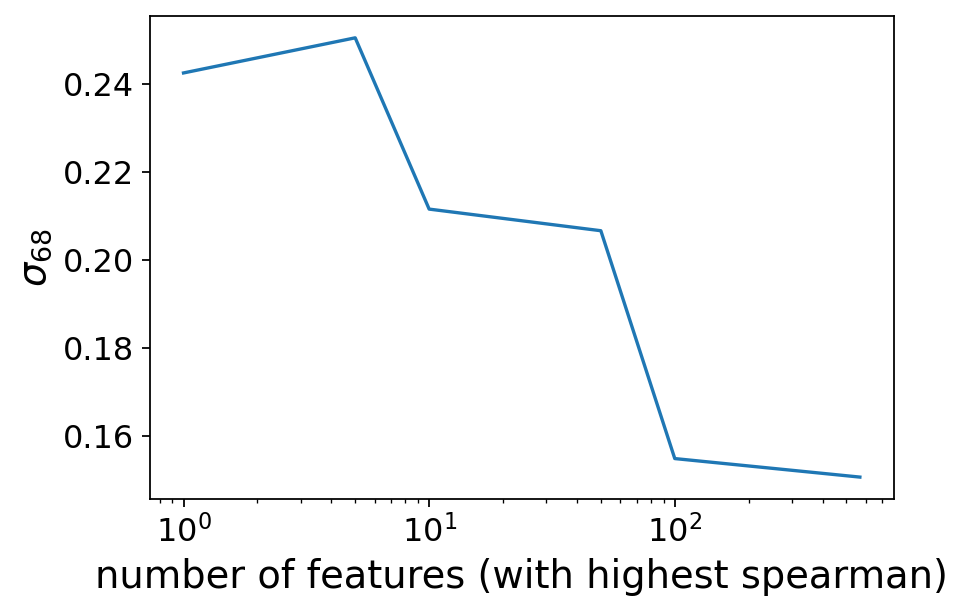

In [126]:
plt.plot(ns_top_features, errors)

plt.xlabel(f'number of features (with highest {info_metric})')
plt.ylabel(r'$\sigma_{68}$')
plt.xscale('log')
#plt.yscale('log')